<a href="https://colab.research.google.com/github/mkorlyakova/test-face-recognition/blob/main/%D0%A0%D0%B5%D0%B0%D0%BB%D0%B8%D0%B7%D0%B0%D1%86%D0%B8%D1%8F_hypothesis_2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Импорт рабочих библиотек**

In [ ]:
import os

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import cv2 as cv
import tarfile


In [ ]:
from scipy.stats import mannwhitneyu
from scipy.stats import wilcoxon
import scipy.stats as st


In [ ]:
import seaborn as sns

Подключение к диску с данными

In [ ]:
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.utils import Sequence

In [ ]:
from google.colab import drive
drive.mount('/gdrive')


Mounted at /gdrive


## *Гипотеза* 2 : 
  **metric lening**

###  Реализация:
 - проводим массивный поиск гиперпараметров:    
      - по функциям потерь
      - по размеру сети
      - по Эмбедингу [32-128]
 - предобработки : ?
 - тренировка сети: выделить валидационный кусок и тренировочный 
 - анализ результат (метрики): accuracy, EER, FAR,FRR





Вопрос: ВАЖЕН ЛИ СПОСОБ СЖАТИЯ из 112 в 32?


In [ ]:
# Генератор данных для обучения
class CustomDataGenFace(Sequence):
  
  
  def __init__(self, 
               batch_size,
               input_size=(32, 32, 3),
               zipfile = '/gdrive/MyDrive/Face recognition/casia_faces.tar.gz',
               lab = 1,
               scale = [32,32],
               shuffle=True,
               ind1 = 1,
               ind2 = 10000):
    """
    batch_size,
    input_size=(32, 32, 3),
    zipfile = '/gdrive/MyDrive/Face recognition/casia_faces.tar.gz',
    lab = 1,
    scale = [32,32],
    shuffle=True,
    ind1 = 1,
    ind2 = 10000
    """

    super().__init__()
    self.__batch_size = batch_size # 1
    self.input_size = input_size # 
    self.shuffle = shuffle
    self.scale = scale
    self.lab = lab # Lab
    self.zipfile = zipfile
    self.ind1 = ind1
    self.ind2 = ind2

    # роткрыть данные из архива на локальный диск
    if self.zipfile.endswith("tar.gz"):
      self.tar = tarfile.open(self.zipfile, "r:gz")
    elif self.zipfile.endswith("tar"):
      self.tar = tarfile.open(self.zipfile, "r:")
    self.ll = self.tar.getmembers( )
    for k in self.ll[ind1:ind2]:
      self.tar.extract( k )
    self.tar.close()


  def __del__():
    
    #self.tar.close()
    super().__del__()
  
  def set_batch_size(self, batch_size):
        self.__batch_size = batch_size
        
 
  def get_batch_size(self):
        return self.__batch_size  


  def label_extract(self,index):
    try:
      #print(index)
      s = self.ll[index].name.split('/')
      """
      if not os.path.exists(self.ll[index].name):
        #print(s)
        self.tar = tarfile.open(self.zipfile, "r:gz")
        self.tar.extract( self.ll[index] ) 
        self.tar.close()
      """  
      #print(self.ll[index])
      if len(s)>2:
      #if s[-2].find('person_')>=0:
        k = s[-2].find('person_')
        #print(k)
        if k>=0:
          label = s[-2][k+7:]
          #print(label)
          return int(label)
        else:
          return -1  
      else:
        return -1
    except FileNotFoundError:
      return -1      
  
  def image_extract(self,index):
    try:
      s = self.ll[index].name
      #print(s)
      img = cv.imread(s )
      if type(img) == type(cv.imread('')) :
        return np.zeros((1,32,32,3)), 0  
      else:
        img = cv.resize(img,(self.scale[1],self.scale[0]))
          
      if self.lab:
        img = cv.cvtColor(img, cv.COLOR_RGB2LAB)
      img = img.reshape(-1,self.scale[1],self.scale[0],3)
      return img, np.mean(img)
    except FileNotFoundError:
      return np.zeros((1,32,32,3)), 0
  
  #rotate image
  def rotation(self, image, angle):
    s = image.shape
    center=tuple(np.array([s[0],s[1]])/2)
    rot_mat = cv.getRotationMatrix2D(center,angle,1.0)
    new_image = cv.warpAffine(image, rot_mat, (s[1],s[0]))
    return 
    
  
    
  def on_epoch_end(self):
    pass

  def getitemIL(self, index):
    #print(index)
    image = []
    label = []
    try:
      i = 0
      
      while (len(label)<1)&(i<10):
        
        k = self.label_extract(index)
        if k>= 0:
          image_, m = self.image_extract(index)
          if m>0:
            label_ = k
            #print(image_.shape, label_)
            image = image_
            label = label_
        i += 1
          
      return np.array(image),np.array(label)
    except FileNotFoundError:
      return np.zeros((1,32,32,3)),-1* np.ones((1, ))
  
  
  def __len__(self):
    
    return len(self.ll) // self.batch_size  
    
  def __getitem__(self, index):
    #print(index)
    image = []
    label = []
    try:
      i = 0
      ind = np.random.randint(0,self.__batch_size, (self.__batch_size*2))
      if (index<self.ind1)or((index+self.__batch_size)>self.ind2):
            if self.zipfile.endswith("tar.gz"):
              self.tar = tarfile.open(self.zipfile, "r:gz")
            elif self.zipfile.endswith("tar"):
              self.tar = tarfile.open(self.zipfile, "r:")
            self.ll = self.tar.getmembers( )
            for k in self.ll[index:index+self.__batch_size]:
              self.tar.extract( k )
            self.tar.close()

      while (len(label)<self.__batch_size)&(i<self.__batch_size*2):
        
        k = self.label_extract(index+ind[i])
        if k>= 0:
          image_, m = self.image_extract(index+ind[i])
          if m>0:
            label_ = k
            #print(image_.shape, label_)
            image.append(image_[0,:,:,:])
            label.append(label_)
        i += 1
          
      return np.array(image),np.array(label)
    except FileNotFoundError:
      return np.zeros((1,32,32,3)),-1* np.ones((1, ))
  def __len__(self):
    
    return len(self.ll) // self.batch_size

Запуск генератора: 
  - читаем каталог примеров на диск
  - задаем размер пакета

In [ ]:
gen_d = CustomDataGenFace(100)

Exception ignored in: <function CustomDataGenFace.__del__ at 0x7f3224572a70>
TypeError: __del__() takes 0 positional arguments but 1 was given


Схема сети для эмбединга: 

 - layer[0] сверточных блоков (С-С-MP)
 - layer[1] полносвязных блоков (FC-Drop)

In [ ]:
EMB_SIZE = 50

def net_creat(EMB_SIZE = 50, im_size = (32,32,3),X_size = 8, layer = [5,3], numb_neuro = 1):
  # поток I
  inp_x_im = tf.keras.layers.Input(shape=(im_size[0], im_size[1], im_size[2]))
  
  x1 = tf.keras.layers.Conv2D(32*numb_neuro, (3, 3), padding='same', activation='relu')(inp_x_im)
  for k in range(layer[0]):
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.Conv2D(64*numb_neuro, (3, 3), padding='same', activation='relu')(x1)
    x1 = tf.keras.layers.MaxPool2D((2, 2), (2, 2))(x1)
    
  x1 = tf.keras.layers.Flatten()(x1)
  # поток Х 
  x = tf.keras.layers.Dense(256, activation='relu')(x1)
  x = tf.keras.layers.Dropout(0.5)(x)
  for k in range(layer[1]):
    x = tf.keras.layers.Dense(EMB_SIZE*numb_neuro, activation='relu')(x)
    x = tf.keras.layers.Dropout(0.5)(x)
  x = tf.keras.layers.Dense(EMB_SIZE, activation=None)(x)

  return tf.keras.models.Model( inputs =inp_x_im, outputs = x)  

In [ ]:
NUM_EPOCHS =5 # число эпох 
NUM_BATCH = 40 # число пакетов

LEARNING_RATE = 0.001 # скорость обучения

# оптимизатор
optimizer = tf.keras.optimizers.Adam(LEARNING_RATE)
# зазор
MARGIN = 100.0

In [ ]:

# https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
# Функция потерь
def contastive_loss(embs, labels):
  # print(embs,labels)
  bs = embs.shape[0]
  embs1 = embs[:bs//2, :]
  embs2 = embs[bs//2:, :]
  
  labels1 = labels[:bs//2]
  labels2 = labels[bs//2:]
  #print(labels1,labels2)
  d2 = tf.reduce_sum(tf.square(embs1 - embs2), axis=1)
  d =  tf.sqrt(d2)
  z = tf.cast(labels1 == labels2, tf.float32)
    
    
  return tf.reduce_mean(z * d2 + (1-z) * tf.maximum(0, MARGIN - d)**2)

# https://www.pyimagesearch.com/2021/01/18/contrastive-loss-for-siamese-networks-with-keras-and-tensorflow/
# Функция потерь
def loss_cos(embs, labels):
  # print(embs,labels)
  bs = embs.shape[0]
  embs1 = embs[:bs//2, :]
  embs2 = embs[bs//2:, :]
  print(embs1,embs2)
  labels1 = labels[:bs//2]
  labels2 = labels[bs//2:]
  print(labels1,labels2)
 
  d2 =tf.keras.losses.cosine_similarity(embs1, embs2, axis =-1 )
  print(d2)
  d =  (d2 - MARGIN)
  z = tf.cast(labels1 == labels2, tf.float64)
  print(z)  
  
  print( (1-z) * tf.maximum(0, MARGIN - d)**2)
    
  return tf.reduce_mean(z * d2 + (1-z)*(-d2))  

In [ ]:
# обучение сиамской сети

def train_step(model, I,L,hist, func_loss = loss_cos):
  '''
  Реализация одного шага обучения (для одной картинки по всем ее рамкам )
  model - модель, 
  I,X,L - признаки и метки, 
  ind - индексы для пакета
  '''

  #print(ind_iter)
  # Forward
  with tf.GradientTape() as tape:
        
        embs = model( I)
        #print(embs.numpy())
       
        loss_value = func_loss(embs, L)
       
        
  # Backward
  grads = tape.gradient(loss_value, model.variables)
  optimizer.apply_gradients(zip(grads, model.variables))
  hist.append(loss_value.numpy())
  if loss_value.numpy()!=0:
            print( loss_value.numpy())
  return model, hist   

In [ ]:
image_shape = []
numb_bound = []
image_shape = []
numb_bound = []
hist = []

In [ ]:
# вычисление метрики для вложеня (Euqlid)
def diff(e1, e2):
    return np.sum((e1 - e2)**2) ** 0.5

# вычисление пар по меткам
#for i in range(len(L)-1):
#  for j in range(i+1,len(L)): 
#    if (lab[j] != -1) & (lab[i] != -1):
#      print(lab[i],' <-> : ',lab[j], ' : ', diff(emb[i], emb[j]))

In [ ]:
gen_d.set_batch_size(100)

In [ ]:
# метрики по эмбедингу (вложению)
def my_embed_metric(X,L):
  net_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  label_dist = np.ones((X.shape[0],X.shape[0])) # нормированное расстояние - инициализация 1(пока)
  for i in range(X.shape[0]-1):
    for j in range(i+1,X.shape[0]):
      net_dist[i,j] = diff( X[i,:],X[j,:])
      net_dist[j,i] =  net_dist[i,j]
      label_dist[i,j] = int(L[i] == L[j])
      label_dist[j,i] =  label_dist[i,j]

      

      
  return net_dist, label_dist# 

def image_clast_net(image_name='',  model=None,  ind=13200,  verbose=1, gen_d  = None):
  '''
  полный цикл для кластер- анализа
  вход:
  image_name - имя картинки, json_arr - имя аннотации, verbose = 0, w = 15
  
  centr = True - строим картинки для данных из центроида (или False - из рамки ), 
  wx - размер половины картинки по любой оси
  w - число пикселей на расширение рамки в стороны  
   
  гиперпараметры алгоритма

  im_proc = 0.1 - часть не отнесенных к кластерам картинок,  
  
  verbose = 1 - визуализировать результат (0 - не визуализировать)

  Строим признаки:
  Х массив векторов в составе:
   - центроиды (сх, су)
   - коробка из данных json (BoundingBox)
   - Размеры по Х, У (ширина , высота)
  I - картинка вокруг центроида (centr = True) или в рамке из box_bound (centr = Falce)
  L - разметка по кластеранализу
  iou,n_dist,m_dist - метрики 
  box_bound_clear - рамки
  
  ''' 

  I = []
  L = []
  
  
  # картинке ставим в соответствие аннотацию
  batch_size = gen_d.get_batch_size()*2
  
 
  if 1:
    # строим признаки 
    I1,L_1 = gen_d[ind]
    I2,L_2 = gen_d[ind+ np.random.randint(5000)]

    I = np.vstack((I1,I2))
    L = np.hstack( (L_1,L_2))

    #смешать данные

    ind1 = np.arange(len(L_1)).tolist()
    
    ind2 = (np.arange(len(L_2)) + (batch_size // 2)).tolist()

    ind  = ind1[::2]+ind2[::2]+ind1[1::2]+ind2[1::2]

    
    I = I[ind,:,:,:]
    L = L[ind]
    print(I.shape,L.shape)
    batch_size = len(L)


    # строим метрики
    if 1:
      
      X_emb = model.predict(I)
      n_emb,l_dist = my_embed_metric(X_emb,L)

      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,3,1)
        plt.imshow(n_emb)
        plt.title('Эмбединг')
        plt.subplot(1,3,2)
        plt.imshow(n_emb * l_dist)
        plt.title('Эмбединг 1')
        plt.subplot(1,3,3)
        plt.imshow(n_emb * (-l_dist+1))
        plt.title('Эмбединг 0')  
        plt.show()
      # анализ  
      Dist1 = []
      Dist0 = []
      for i in range(batch_size):
        for j in range(i+1,batch_size-1):
          if l_dist[i,j] :
            Dist1.append(n_emb[i,j])
          else:
            Dist0.append(n_emb[i,j])  
      if verbose:
        plt.figure(figsize = (16,5))
        plt.subplot(1,2,1)
        plt.hist(Dist0,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 0')
        plt.hist(Dist1,alpha = 0.5,bins = 100, label = 'labeli!=labelj : 1')
        plt.legend()
      
        plt.grid(True)
        plt.title('распределение рaсстояний по типам пар')
        plt.subplot(1,2,2)
        sns.kdeplot(Dist0,)
        sns.kdeplot(Dist1)
        plt.grid(True)
        plt.legend()
        plt.title('распределение рaсстояний по типам пар')
        plt.show()
      m0 = np.mean(Dist0)
      m1 = np.mean(Dist1)
      print('средняя дистанция по 0:',m0)
      print('средняя дистанция по 1:',m1)
      d0 = np.std(Dist0)
      d1 = np.std(Dist1)

      L1 = len(Dist1)
      L0 = len(Dist0)
      if L1>L0:
        L_d01 = L0
      else:
        L_d01 = L1  
      print('std по 0:',d0)
      print('std по 1:',d1)
      conf_int0 = st.t.interval(0.99, len(Dist0)-1, loc=np.mean(Dist0), scale=st.sem(Dist0))
      conf_int1 = st.t.interval(0.99, len(Dist1)-1, loc=np.mean(Dist1), scale=st.sem(Dist1))
      print('доверит.интервал 0',conf_int0)
      print('доверит.интервал 1',conf_int1)
      print('интервал 3 sigms 0',[m0-d0*3,m0+d0*3])
      print('интервал 3 sigma 1',[m1-d1*3,m1+d1*3])
      if verbose:
        plt.plot([0,0,0],[conf_int0[0],m0,conf_int0[1]],'-og', label='0')
        plt.plot([1,1,1],[conf_int1[0],m1,conf_int1[1]], '-ok',label='1')
        plt.plot([0,0,0],[m0-d0*3,m0,m0+d0*3],'--xb', label='3 sigma 0')
        plt.plot([1,1,1],[m1-d1*3,m1,m1+d1*3], '--xr',label='3 sigma 1')
        plt.legend()
        plt.title('доверит.интервал по типам пар и 3sig')
        plt.show()
      wc = wilcoxon(Dist1[:L_d01],Dist0[:L_d01])[1]
      mu = mannwhitneyu(Dist1,Dist0)[1]
      print('тест Мана-Уитни p_value:', mu)
      print('тест Вилкокса p_value:', wc)
      stat_rez = [m0,m1,d0,d1,conf_int0[0],conf_int0[1],conf_int1[0],conf_int1[1],mu,wc,m0-d0*3,m0+d0*3,m1-d1*3,m1+d1*3]

      
    else:
      print('нет фичей')
  else:
    print('не найден файл')
  return I, L, n_emb, l_dist, stat_rez

In [ ]:
# Предсказание

def L2_metric(X1,X2):
  return np.sum((X1-X2) ** 2) ** 0.5
def cos_metric(X1,X2):
  return np.dot(X1.T/(np.sum(X1*X1))**0.5,X2/(np.sum(X2*X2))**0.5) 

def predict(I1,I2,model):
  I = np.array([I1[:,:,:],I2[:,:,:]])
  X_emb = model.predict(I)
  n_emb = L2_metric(X_emb[0,:],X_emb[1,:])
  return n_emb


def pred_batch(ind, model,gen_d):
  I,L = gen_d[ind]
  n_emb = []
  for i in range(len(L)//2):
    p = predict(I[i,:,:,:],I[len(L)//2+i,:,:,:],model)
    #print(p,I[i,:,:,:].mean(),I[len(L)//2+i,:,:,:].mean())
    n_emb.append([p, int(L[i]==L[len(L)//2+i])])  
  return n_emb



In [ ]:
# https://habr.com/ru/post/317798/

def calc_metrics(targets_scores, imposter_scores):
    """
    targets_scores - значения выхода модели через метрику для пар, 
    imposter_scores - значения выхода модели через метрику для не пар,
    """
    # диапазоны
    min_score = np.minimum(np.min(targets_scores), np.min(imposter_scores))
    max_score = np.maximum(np.max(targets_scores), np.max(imposter_scores))
    print(min_score,max_score)
    n_tars = len(targets_scores)
    n_imps = len(imposter_scores)

    N = 100

    fars = np.zeros((N,))
    frrs = np.zeros((N,))
    dists = np.zeros((N,))

    mink = float('inf')
    eer = 0
    min_i = 0
    # поиск оптимальной точки
    for i, dist in enumerate(np.linspace(min_score, max_score, N)):
        far = len(np.where(imposter_scores > dist)[0]) / n_imps
        frr = len(np.where(targets_scores < dist)[0]) / n_tars
        # добавили оценки по этому порогу для dist
        fars[i] = far
        frrs[i] = frr
        dists[i] = dist

        k = np.abs(far - frr)

        if k < mink:
            mink = k
            min_i = i
            eer = (far + frr) / 2
    # accuracy

    if n_tars>n_imps:
      nn = n_imps
    else:
      nn = n_tars
    TN = np.sum(imposter_scores[:nn] > dists[min_i]) 
    TP = np.sum(targets_scores[:nn] < dists[min_i])
    acc = (TP+TN)/(nn*2)


    return eer, fars, frrs, dists, min_i, acc

Есть перспектива. Работаем на поиск модели:

  - гиперпараметры: 
        - размер эмбединга
        - размер сети
        - лосс : перейти на cos 
        - размер пакета
        - параметры оптимизитора

  - доработать генератор:   
        - строить более сложный пакет - на один шаг обучения брать 2 точки из генератора ( перенести раскрытие архива в инициализацию - кусками по тексту архива )

  - написать метрику для финальной оценки 
  - уточнить тип метрики - завтра утром  

Дизайн эксперимента:
  - размер эмбединга [16,32,64,128,256,512] 
  - размер входа 32х32х3 = 3072 - брать вложение(эмбединг) сильно больше не вижу смысла (пока)  
  - по итогам первого этапа оценки приняли размер эмбединга 64
  - размер сети (уложить размеры до 1М параметров - т.к. вход маленький) 
  - меняем число сверточных и полносвязных блоков от 1 до 4
  - оцениваю различимость выборок расстояний для похожих и разных пар (стат.тесты: Манн-Уитниб Вилкокс - не параметрические, 2-хвыборочные)
  - оцениваю кривые FAR/FRR
  - строю визуальный контроль для распределений


  - Сделаем по 5-10 повторов каждой конфигурации с новыми начальными параметрами

  - Использую 5 эпох и 1000 пакетов в эпохе из случайного полождения генератора в интервале до 400000 для тренировки и после 400000 для теста

In [ ]:
# Эксперимент

rez = pd.DataFrame(data = np.zeros((120,18)), columns = ['Embed_size','dense_l','conv_l','loss_func','m0','m1','d0','d1','conf_int0[0]','conf_int0[1]','conf_int1[0]','conf_int1[1]','mu','wc','m0 -3s0','m0+3s0','m1 -3s1','m1+3s1']) 


In [ ]:
rez.to_csv('/gdrive/MyDrive/Face recognition/rez.csv')

In [ ]:


epoch = 5
m = 0
for EMB_SIZE in  [64]:
  for conv_l in [1,2,3,4]:
    for dense_l in range(3):
      LF = 0
      for loss_func in [contastive_loss]:
        LF += 1
        plt.figure(figsize = (16,5))
        for n in range(5):
          model = net_creat(EMB_SIZE = EMB_SIZE, im_size = (32,32,3),X_size=8, layer = [conv_l,dense_l], numb_neuro=1)
          image_shape = []

          image_shape = []
          numb_bound = []
          hist = []
          for ch in range(NUM_EPOCHS):
            for i in range(1,10):
              ind_i = np.random.randint(0,10000)
              I,L = gen_d[ind_i]
    
              model, hist = train_step(model, I,L, hist,loss_func)
          plt.subplot(1,2,1)
          plt.plot(hist )
          model.save_weights('/gdrive/MyDrive/Face recognition/'+'siam_net_'+str(EMB_SIZE)+'_'+str(k)+'_'+str(n) +'_.h5')
          I, L, n_emb, l_dist,stats_rez = image_clast_net(image_name='',  model=model,  ind=12100,  verbose=1, gen_d = gen_d)
          rez.iloc[m,:] =[EMB_SIZE,dense_l,conv_l, 0 ]+ stats_rez
          m += 1
          rez.to_csv('/gdrive/MyDrive/Face recognition/rez.csv')
          r_embed  = pred_batch(12100, model,gen_d)
          del model
          r_embed = np.array(r_embed)
          ind1 = np.where(r_embed[:,1] == 1)[0]
          ind0 = np.where(r_embed[:,1] == 0)[0]

          eer,far,frr,dist_, pdist, acc = calc_metrics(r_embed[ind1,0],r_embed[ind0,0])plt.subplot(1,2,2)
          plt.plot(far.frr)
          
        plt.subplot(1,2,1)
        plt.grid(True)
        plt.xlabel('epoch')
        plt.ylabel('loss')
        plt.title(' dense '+str(dense_l)+' conv:'+str(conv_l))
        plt.subplot(1,2,2)
        plt.grid(True)
        plt.xlabel('dist')
        plt.ylabel('eer')
        plt.show()  

In [ ]:
df = pd.read_csv('/gdrive/MyDrive/Face recognition/rez.csv', index_col=[0])

df.head()

In [ ]:
df.groupby(['dense_l','conv_l']).mean()

In [ ]:
# https://www.sigma-is.ru/files/article/art_ab_nic_5_2015.pdf
# https://habr.com/ru/post/317798/

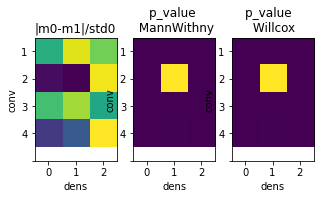

In [ ]:
im1 = np.abs((df.m0-df.m1)/df.d0).values[1:13].reshape(4,3)
im2 = df.mu.values[1:13].reshape(4,3)
im2 = df.wc.values[1:13].reshape(4,3)
plt.figure(figsize=(5,14))
plt.subplot(1,3,1)
plt.imshow(im1)
plt.xticks(np.arange(3), ['0','1','2','3','4'])
plt.yticks(np.arange(5), ['1','2','3','4'])
plt.xlabel('dens')
plt.ylabel('conv')
plt.title('|m0-m1|/std0')
plt.subplot(1,3,2)
plt.imshow(im2)
plt.xticks(np.arange(3), ['0','1','2','3','4'])
plt.yticks(np.arange(5), ['1','2','3','4'])
plt.xlabel('dens')
plt.ylabel('conv')
plt.title('p_value \n MannWithny')
plt.subplot(1,3,3)
plt.imshow(im2)
plt.xticks( np.arange(3), ['0','1','2','3','4'])
plt.yticks(np.arange(5), ['1','2','3','4'])
plt.xlabel('dens')
plt.ylabel('conv')
plt.title('p_value  \n Willcox')
plt.show()


Резюме поиска размера гипотезы 2: 
  - лучшие значения по отношению расстояние между m1, m0 к отношению с рассеиванием sigma0 : число блоков FC = 2, число блоков Сonv = 1
  - по тестам все варианты  кроме [1,1] - рабочие.

  Необходимо построить оценку сетей с метриками на отложенной выборке, пока не lfw.

  1) Построить механизм предсказания для отложенной выборки

  2) Механизм анализа модели(метрики https://habr.com/ru/post/317798/):

    - Accuracy = (TP+TN)/(FP+FN+TP+TN)
    - ERR 
    - FAR
    - FFR


In [ ]:
len(gen_d.ll)

501196

## **Обучение модели:**

- выбраные гиперпараметры: layer = [1,2], EMB_SIZE = 64,пакет на вход модели  100 объектов (выдача генератора)
- обучаем на части доступных данных : первые 400000 объектов, валидация после 400000
- сдвигаю область текущих примеров для обучения в диапазоне от 1 до 400000 (экономим размер места на диске)
- Записываю веса нейронки после  каждой эпохи на диск
- Меняю состав тренировочной и валидационной выборки в пределах отделенных для этого данных
-фиксирую: статистики, EER,FAR,FRR, Accuracy(на выравниваемой выборке по label)

In [ ]:
model = net_creat(EMB_SIZE = 64, im_size = (32,32,3),X_size=8, layer = [1,2], numb_neuro=1)
image_shape = []
image_shape = []
numb_bound = []
hist = []
acc_ = []
eer_ = []

In [ ]:


NUM_EPOCHS = 5
plt.figure(figsize = (16,5))
loss_func = contastive_loss
for ch in range(NUM_EPOCHS):
  for i in range(1,10000,100):
    ind_i = np.random.randint(0,300000)
    I,L = gen_d[ind_i]

    model, hist = train_step(model, I,L, hist,loss_func)

  model.save_weights('/gdrive/MyDrive/Face recognition/siam_net_rez_.h5')
  ind_test = 300000+np.random.randint(0,10000)
  I, L, n_emb, l_dist,stats_rez = image_clast_net(image_name='',  model=model,  ind=ind_test,  verbose=1, gen_d = gen_d)
  
  plt.subplot(1,2,1)
  plt.plot(hist )
  r_embed = []
  for i in range(n_emb.shape[0]):
    for j in range(i+1,n_emb.shape[0]-1):
      r_embed.append( [n_emb[i,j],l_dist[i,j]]) 
  #r_embed  =pred_batch(ind_test, model,gen_d)
  r_embed = np.array(r_embed)
  ind1 = np.where(r_embed[:,1] == 1)[0]
  ind0 = np.where(r_embed[:,1] == 0)[0]
   
  eer,far,frr,dist_, pdist, acc = calc_metrics(r_embed[ind1,0],r_embed[ind0,0])
  
  plt.subplot(1,2,2)
  plt.plot(far,frr, label ='epoch '+str(ch) )
  plt.plot(far[pdist],frr[pdist],'ro', label ='eer '+str(ch) )
  eer_.append(eer)
  acc_.append(acc)
plt.subplot(1,2,1)
plt.grid(True)
plt.xlabel('epoch')
plt.ylabel('loss')

plt.subplot(1,2,2)
plt.grid(True)
plt.title(' FAR/FRR ')
plt.xlabel('FAR')
plt.ylabel('FRR')
plt.legend()
plt.show()  

2292.2524
581.5946


In [ ]:
r_embed = np.array(r_embed)

No handles with labels found to put in legend.


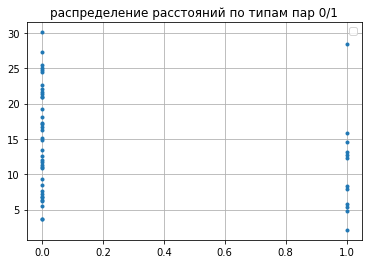

In [ ]:
plt.plot(r_embed[:,1],r_embed[:,0],'.')
plt.grid(True)
plt.legend()
plt.title('распределение рaсстояний по типам пар 0/1')
plt.show()

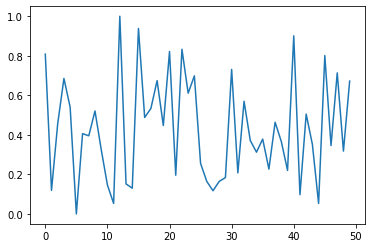

In [ ]:
plt.plot((r_embed[:,0] - r_embed[:,0].min())/(r_embed[:,0].max() - r_embed[:,0].min()))

In [ ]:
ind1 = np.where(r_embed[:,1] == 1)[0]
ind0 = np.where(r_embed[:,1] == 0)[0]
(r_embed[:,0])
eer,far,frr,dist_ = calc_metrics(r_embed[ind1,0],r_embed[ind0,0])

0.0 1.0


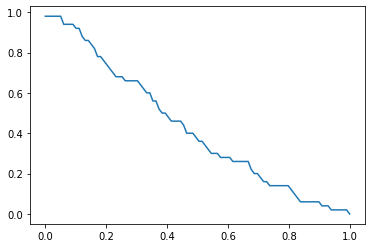

In [ ]:
plt.plot(far,frr)

In [ ]:
eer

0.76